
Project by **Sujata Surendranathan**

BATCH: **PGP-AIML-BA-UTA-OCT24-C**

# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [1]:
import os
import numpy as np# Importing numpy for Matrix Operations
import pandas as pd# Importing pandas to read CSV files
import matplotlib.pyplot as plt# Importting matplotlib for Plotting and visualizing images
import math# Importing math module to perform mathematical operations
import cv2# Importing openCV for image processing
import seaborn as sns# Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator# Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential# Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD# Importing the optimizers which can be used in our model
from sklearn import preprocessing# Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split# Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16# Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Setting a fixed seed value to make sure results stay the same every time the code runs, which helps in testing and comparing models fairly.

In [2]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the image file of the dataset
images = np.load('/content/sample_data/images_proj.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/sample_data/Labels_proj.csv')

In [6]:
#Checking shape of data
print(images.shape)
print(labels.shape)

(631, 200, 200, 3)
(631, 1)


# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

Showing the image at position 139 from the images list to see what it looks like.

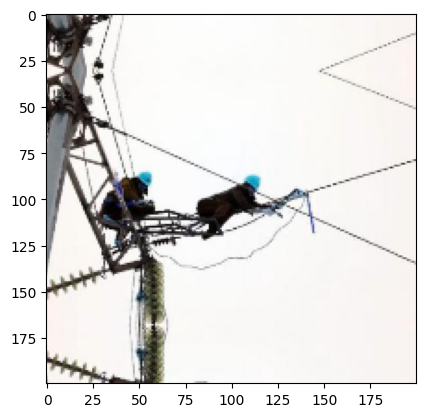

In [7]:
plt.imshow(images[139])

Defining a function to randomly show 12 images with their labels ("With Helmet" or "Without Helmet") in a 3x4 grid, so you can quickly check what the data looks like.

In [8]:
def plot_images(images, labels):
    # Convert labels to a NumPy array and flatten it
    labels_flat = labels.values.flatten()  # Convert DataFrame to NumPy array and flatten

    # Define the label mapping
    keys = {0: 'Without Helmet', 1: 'With Helmet'}

    # Set the number of rows and columns for displaying images
    rows = 3
    cols = 4
    fig = plt.figure(figsize=(10, 8))  # Set the figure size

    # Loop through and display images randomly
    for i in range(rows):
        for j in range(cols):
            random_index = np.random.randint(0, len(labels))  # Random index for selecting an image
            ax = fig.add_subplot(rows, cols, i * cols + j + 1)  # Add subplot with rows and cols
            ax.imshow(images[random_index])  # Plot the image
            ax.set_title(keys[labels_flat[random_index]])  # Display the corresponding label
            ax.axis('off')  # Hide the axes

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

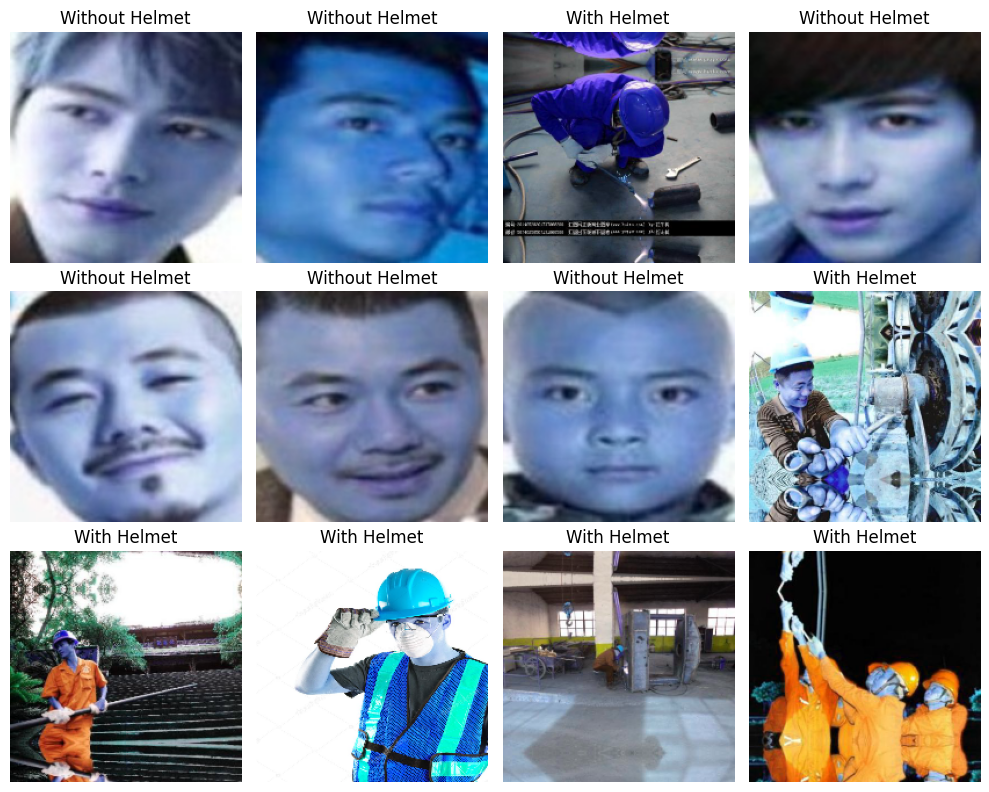

In [9]:
#using the function to plot random images with labels
plot_images(images,labels)

## Checking for class imbalance


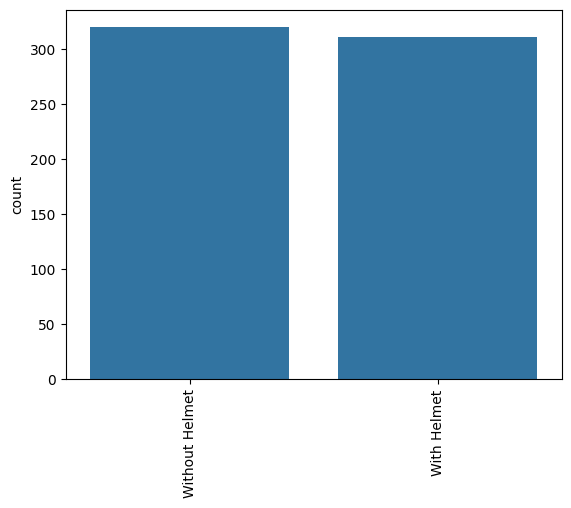

In [10]:
# Flattening the 'Label' column of the DataFrame into a 1D array for easier plotting
labels_flat = labels['Label'].values.flatten()

# Creating a count plot for the two classes
sns.countplot(x=labels_flat)
plt.xticks([0, 1], ['Without Helmet', 'With Helmet'], rotation='vertical')  # Customize x-tick labels
plt.show()

**Observations**

The data set is quite balanced with both categories containing aroudn 300 images each.

# **Data Preprocessing**

#### Converting to Grayscale

In [11]:
gray_images = []
for i in range(len(images)):
  gray_images.append(cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY))

In [12]:
# Function to plot the original and processed images side by side
def grid_plot(img1,img2,gray=False):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(img1)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    if gray:
      axes[1].imshow(img2,cmap='gray')
    else:
      axes[1].imshow(img2)
    axes[1].set_title('Processed Image')
    axes[1].axis('off')

    plt.show()

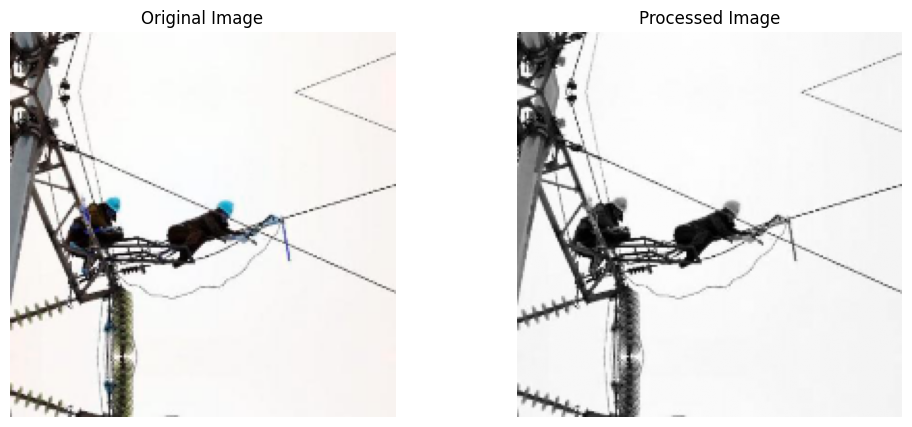

In [13]:
# choosing an image
n = 139
# plotting the original and preprocessed image
grid_plot(images[n],gray_images[n],gray=True)

The images have been successfully converted into grayscale.

#### Reducing size of the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [14]:
images_decreased = []
height = 64
width = 64
dimensions = (width, height)

for i in range(len(gray_images)):
    resized = cv2.resize(gray_images[i], dimensions, interpolation=cv2.INTER_LINEAR)[..., np.newaxis]
    images_decreased.append(resized)

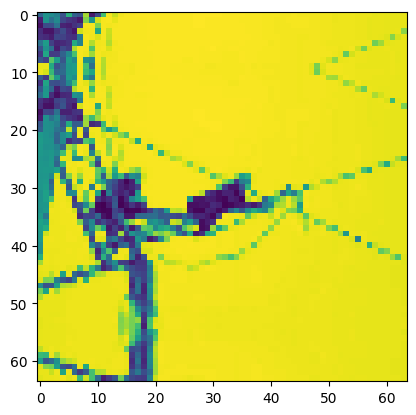

In [15]:
plt.imshow(images_decreased[139]);

### Splitting the dataset



- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

In [16]:
# Adding the channel dimension (for grayscale images)
X = np.array(images_decreased)[..., np.newaxis]

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(np.array(images_decreased),labels , test_size=0.2, random_state=42,stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp , test_size=0.5, random_state=42,stratify=y_temp)

In [18]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(504, 64, 64, 1) (504, 1)
(63, 64, 64, 1) (63, 1)
(64, 64, 64, 1) (64, 1)


In [19]:
# Encoding target labels
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

### Data Normalization

In [20]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

# **Model Building**

##Model Evaluation Criterion

Since the classes are balanced, the key evaluation criteria based on the objective are:

* **Accuracy**, which  measures the overall correctness of the model’s predictions.

* **Precision**, which indicates how many of the predicted "Without Helmet" cases were actually correct, helping reduce false alarms.

* **Recall**, which shows how well the model identifies all the actual "Without Helmet" cases, minimizing missed violations.

* **F1 Score**, which balances precision and recall, providing a single metric that accounts for both false positives and false negatives.

In this case, **Accuracy** will be our focus because we want our model to be able to differentiate images with and without helmet appropriately.

## Utility Functions

In [21]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [22]:
# defining a function to plot the confusion matrix
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

As the images are in grayscale, we will eshape the arrays to just have a single channel

In [42]:
#reshaping array to include channel
X_train = X_train.reshape((504, 64, 64, 1))

In [43]:
# Reshape dataset to have a single channel
X_train = X_train.reshape((X_train.shape[0], 64, 64, 1))
X_test = X_test.reshape((X_test.shape[0], 64, 64, 1))

In [55]:
# Creating one-hot encoded representation of target labels
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [112]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [113]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [114]:
# Intializing a sequential model
model_1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 1)))

# Adding max pooling to reduce the size of output of first conv layer
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_1.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model_1.add(Dense(100, activation='relu'))

# Adding the output layer with 2 neurons and sigmoid activation functions since this is a binary classification problem
model_1.add(Dense(2, activation='sigmoid'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.001, momentum=0.95)

# Compile model
model_1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       204,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,454 (911.93 KB)

 Trainable params: 233,454 (911.93 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
#Training model_1 on normalized training data with 15 epochs, 10% validation, and batch size of 32 and displaying training progress
history_1 = model_1.fit(
            X_train_normalized, y_train_encoded,
            epochs=15,
            validation_split=0.1,
            shuffle=True,
            batch_size=32,
            verbose=2
)

Epoch 1/15
15/15 - 3s - 194ms/step - accuracy: 0.5077 - loss: 0.6949 - val_accuracy: 0.5294 - val_loss: 0.6938
Epoch 2/15
15/15 - 0s - 11ms/step - accuracy: 0.5629 - loss: 0.6929 - val_accuracy: 0.7451 - val_loss: 0.6914
Epoch 3/15
15/15 - 0s - 22ms/step - accuracy: 0.7594 - loss: 0.6905 - val_accuracy: 0.6667 - val_loss: 0.6891
Epoch 4/15
15/15 - 0s - 14ms/step - accuracy: 0.5453 - loss: 0.6883 - val_accuracy: 0.5098 - val_loss: 0.6870
Epoch 5/15
15/15 - 0s - 17ms/step - accuracy: 0.5011 - loss: 0.6859 - val_accuracy: 0.4706 - val_loss: 0.6843
Epoch 6/15
15/15 - 0s - 12ms/step - accuracy: 0.5232 - loss: 0.6832 - val_accuracy: 0.5490 - val_loss: 0.6812
Epoch 7/15
15/15 - 0s - 20ms/step - accuracy: 0.5497 - loss: 0.6801 - val_accuracy: 0.5882 - val_loss: 0.6774
Epoch 8/15
15/15 - 0s - 12ms/step - accuracy: 0.5806 - loss: 0.6764 - val_accuracy: 0.6275 - val_loss: 0.6728
Epoch 9/15
15/15 - 0s - 19ms/step - accuracy: 0.5960 - loss: 0.6718 - val_accuracy: 0.6078 - val_loss: 0.6674
Epoch 10/

Model 1 shows a steady improvement, with the accuracy increasing from 50.7% to 86.3% and the validation accuracy rising from 52.94% to 90.20%.

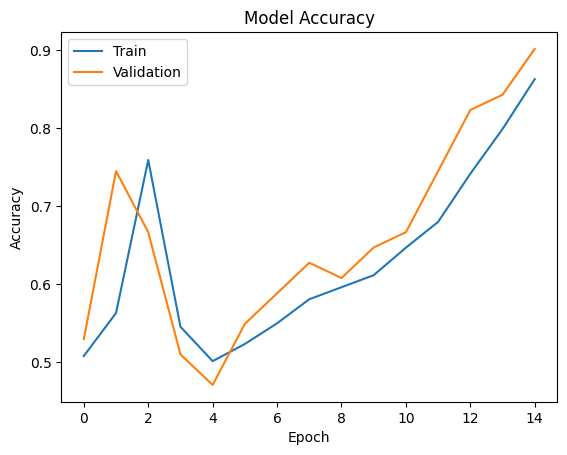

In [116]:
# Plotting the training and validation accuracy over epochs helps visualize the model's performance and learning progress.
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [117]:
# Generating predictions (y_pred) for the test data X_test_normalized using the trained model.
y_pred=model_1.predict(X_test_normalized)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


In [118]:
#Displaying the predicted probabilities for each test sample, indicating how likely it is that each belongs to class 1 (with helmet).
y_pred

array([[0.507253  , 0.48546937],
       [0.48754853, 0.49825865],
       [0.5173666 , 0.4637594 ],
       [0.5070509 , 0.47311163],
       [0.5122192 , 0.47986025],
       [0.40197882, 0.61307   ],
       [0.4154688 , 0.6149137 ],
       [0.42859706, 0.59162086],
       [0.46417034, 0.537433  ],
       [0.5068605 , 0.4805137 ],
       [0.35190356, 0.6878007 ],
       [0.3298289 , 0.69915855],
       [0.43237016, 0.58026224],
       [0.4549996 , 0.5500818 ],
       [0.48974404, 0.5094977 ],
       [0.37033847, 0.6695707 ],
       [0.50894624, 0.47834608],
       [0.52268296, 0.46073526],
       [0.48635364, 0.5105919 ],
       [0.50036126, 0.49658653],
       [0.42315224, 0.5961594 ],
       [0.51004386, 0.4753972 ],
       [0.5055942 , 0.48239446],
       [0.40522867, 0.6153364 ],
       [0.4583021 , 0.553043  ],
       [0.50075155, 0.49716958],
       [0.42554834, 0.5771519 ],
       [0.5222944 , 0.46508047],
       [0.40092835, 0.6319282 ],
       [0.51354766, 0.4748485 ],
       [0.

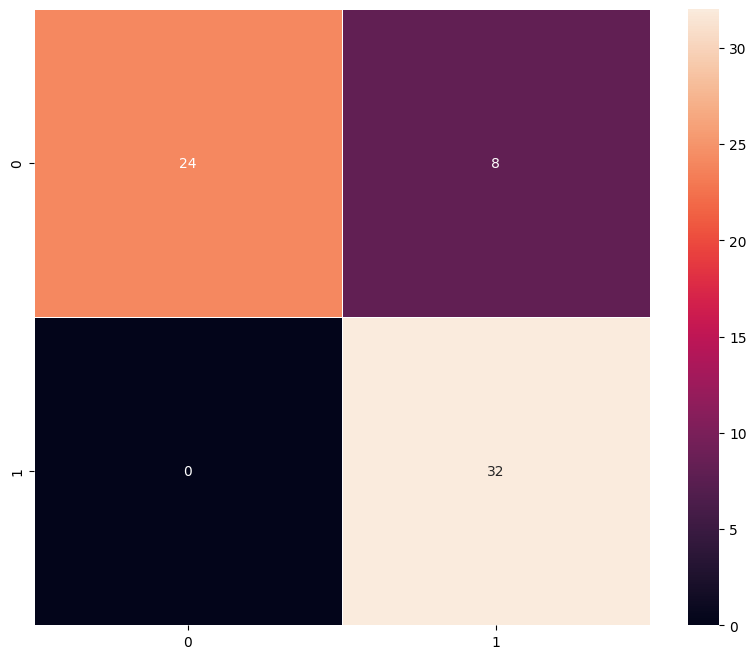

In [119]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

### Vizualizing the predictions

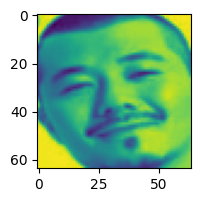

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
Predicted Label [1]
True Label 0


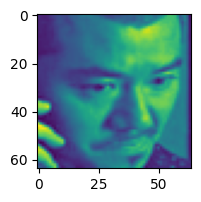

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Label [0]
True Label 1


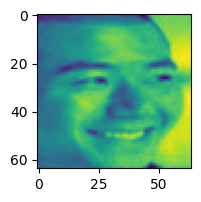

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Label [0]
True Label 1


In [120]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model_1.predict((X_val_normalized[2].reshape(1,64,64,1)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model_1.predict((X_val_normalized[33].reshape(1,64,64,1)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_val[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model_1.predict((X_val_normalized[36].reshape(1,64,64,1)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])

**Observations on Model 1**

* The model is performing well, achieving an accuracy of 89.62% on the training data and 94.12% on the validation set by the final epoch.

* The loss consistently decreases throughout the training, indicating the model is effectively learning and making better predictions.

* Overall, the model shows strong performance and good generalization to unseen data.

## Model 2: (VGG-16 (Base))

Before we build the model, we will use the original color images as VGG works best with RGB. We will proceed to resize it to reduce computational usage.

In [121]:
## Resize all images to 64x64 pixels and store them in images_decreased_rgb
images_decreased_rgb = []
height = 64
width = 64
dimensions = (width, height)

for i in range(len(images)):
    resized = cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR)
    images_decreased_rgb.append(resized)

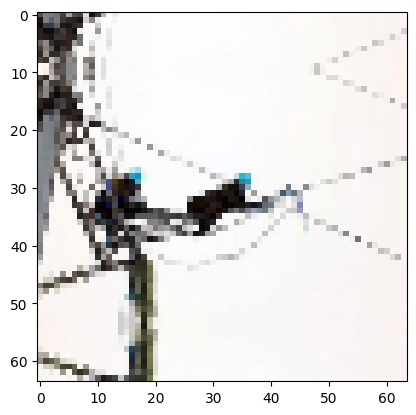

In [122]:
#Plotting image #139 with decreased size
plt.imshow(images_decreased_rgb[139]);

Now we will split the data into train and test, using RGB images with reduced size

In [123]:
#splitting data into test, and train
X_train, X_temp, y_train, y_temp = train_test_split(np.array(images_decreased_rgb),labels , test_size=0.2, random_state=42,stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp , test_size=0.5, random_state=42,stratify=y_temp)

In [124]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(504, 64, 64, 3) (504, 1)
(63, 64, 64, 3) (63, 1)
(64, 64, 64, 3) (64, 1)


In [125]:
## Encode the target labels into binary format using LabelBinarizer
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

In [126]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

In [127]:
# Loading the VGG16 model with pre-trained ImageNet weights, excluding the top layers
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(64,64,3))
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [128]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [129]:
model_2 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_2.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_2.add(Flatten())

# Adding a dense output layer
model_2.add(Dense(1, activation='sigmoid'))

In [130]:
#using adam optimizer
opt=Adam()
# Compile model
model_2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [131]:
# Generating the summary of the model
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,716,737 (56.14 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [132]:
# Initialize an ImageDataGenerator for data augmentation or preprocessing
train_datagen = ImageDataGenerator()

In [133]:
# Epochs
epochs = 20
# Batch size
batch_size = 128

history_vgg16 = model_2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=True),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.5998 - loss: 0.6613 - val_accuracy: 0.8095 - val_loss: 0.5450
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8828 - loss: 0.5259 - val_accuracy: 0.8730 - val_loss: 0.5017
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9207 - loss: 0.4668 - val_accuracy: 0.9841 - val_loss: 0.3912
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9375 - loss: 0.3885 - val_accuracy: 0.9841 - val_loss: 0.3602
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9723 - loss: 0.3292 - val_accuracy: 1.0000 - val_loss: 0.2834
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9917 - loss: 0.2812 - val_accuracy: 1.0000 - val_loss: 0.2624
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9759 - loss: 0.2521 - val_accuracy: 1.0000 - val_loss: 0.2109
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9922 - loss: 0.2032 - val_accuracy: 1.0000 - val_loss: 0.196

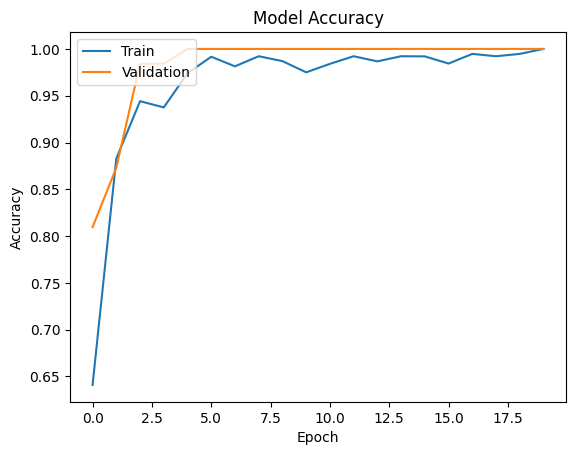

In [134]:
# Plotting training and validation accuracy over epochs
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [135]:
# Evaluating and print the performance metrics of model_2 on the training data
model_2_train_perf = model_performance_classification(model_2, X_train_normalized,y_train_encoded)

print("Train performance metrics")
print(model_2_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step
Train performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.996032  0.996032   0.996032  0.996032


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


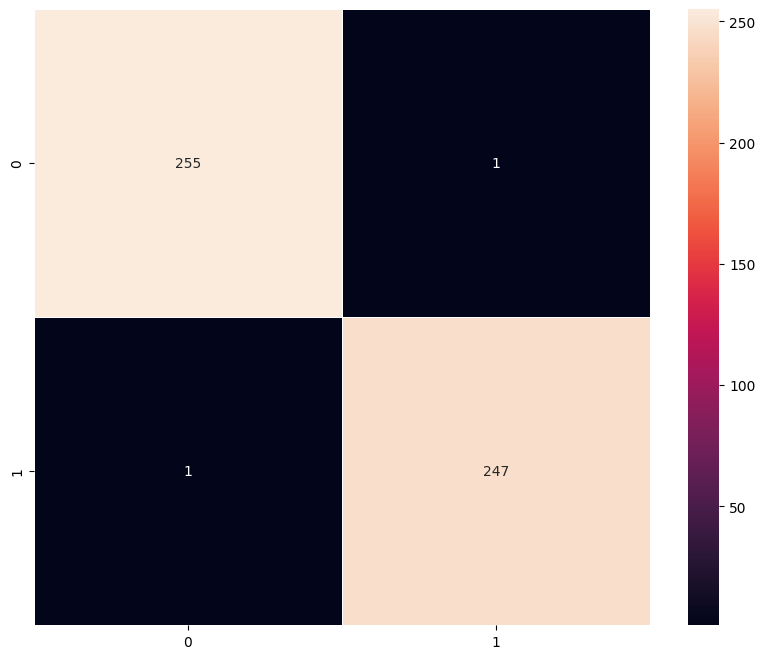

In [136]:
plot_confusion_matrix(model_2,X_train_normalized,y_train_encoded)

In [137]:
# Evaluating and print the performance metrics of model_2 on the validation data
model_2_valid_perf = model_performance_classification(model_2, X_val_normalized,y_val_encoded)

print("Validation performance metrics")
print(model_2_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


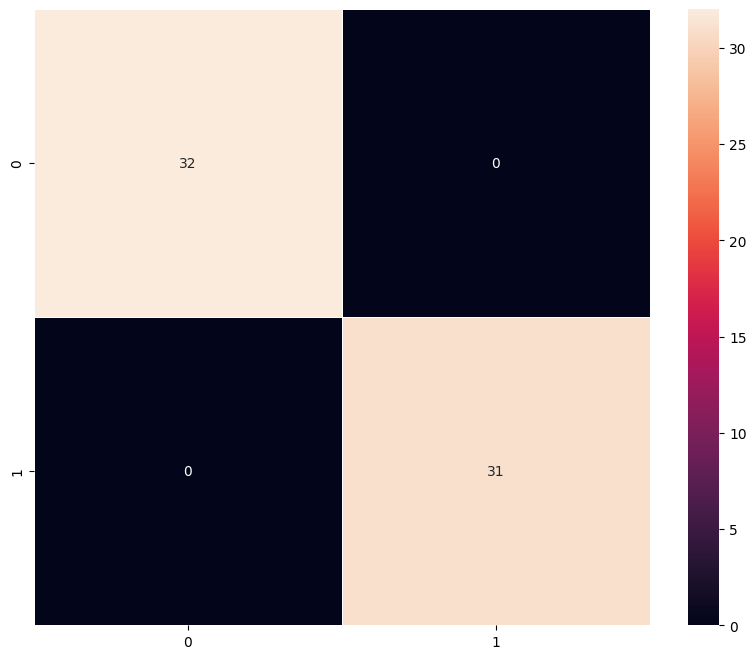

In [138]:
plot_confusion_matrix(model_2,X_val_normalized,y_val_encoded)

### Visualizing the prediction:

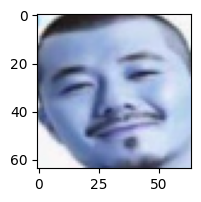

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
Predicted Label [0]
True Label 0


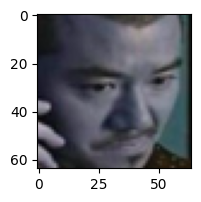

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Label [0]
True Label 1


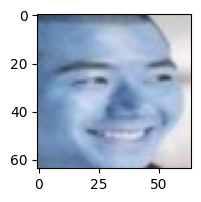

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Label [0]
True Label 1


In [139]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model_2.predict((X_val_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model_2.predict((X_val_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_val[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model_2.predict((X_val_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])

## Model 3: (VGG-16 (Base + FFNN))

- We will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will add a Flatten layer and a Feed Forward Neural Network.

In [140]:
# Build a sequential model combining VGG16 convolutional base and a feed-forward network
model_3 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_3.add(Flatten())

#Adding the Feed Forward neural network
model_3.add(Dense(256,activation='relu'))
model_3.add(Dropout(rate=0.5))
model_3.add(Dense(32,activation='relu'))

# Adding a dense output layer
model_3.add(Dense(1, activation='sigmoid'))

In [141]:
opt = Adam()

In [142]:
# Compile model
model_3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [143]:
# Generating the summary of the model
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,247,489 (58.16 MB)

 Trainable params: 532,801 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [144]:
# Training model_3 using data from train_datagen with batching and validation
history_vgg16 = model_3.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6873 - loss: 0.5949 - val_accuracy: 1.0000 - val_loss: 0.1027
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9688 - loss: 0.1488 - val_accuracy: 1.0000 - val_loss: 0.0563
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9921 - loss: 0.0636 - val_accuracy: 1.0000 - val_loss: 0.0106
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9922 - loss: 0.0350 - val_accuracy: 1.0000 - val_loss: 0.0069
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9901 - loss: 0.0188 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9919 - loss: 0.0177 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9844 - loss: 0.0194 - val_accuracy: 1.0000 - val_loss: 0.0016

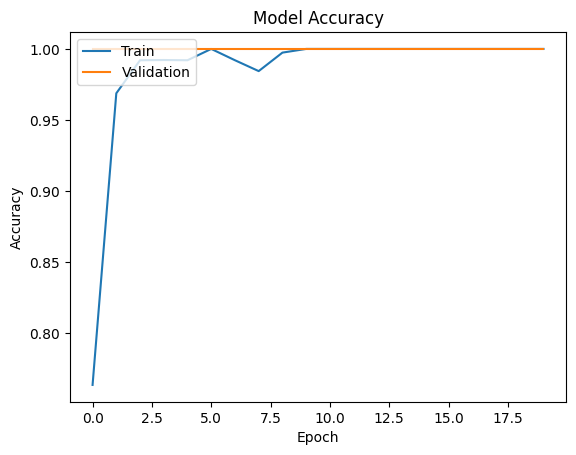

In [145]:
# Plotting training and validation accuracy over epochs
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [146]:
model_3_train_perf = model_performance_classification(model_3, X_train_normalized,y_train_encoded)

print("Train performance metrics")
print(model_3_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


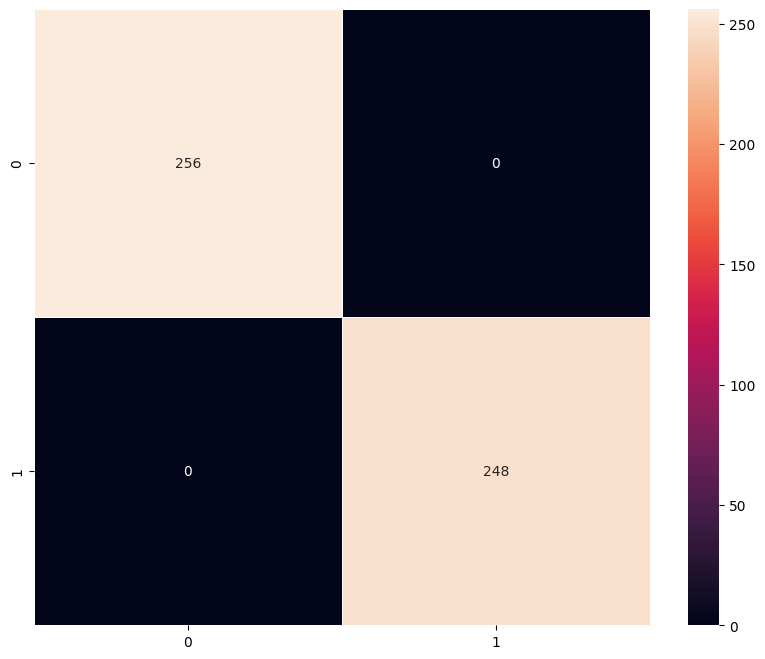

In [147]:
plot_confusion_matrix(model_3,X_train_normalized,y_train_encoded)

In [148]:
model_3_valid_perf = model_performance_classification(model_3, X_val_normalized,y_val_encoded)

print("Validation performance metrics")
print(model_3_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


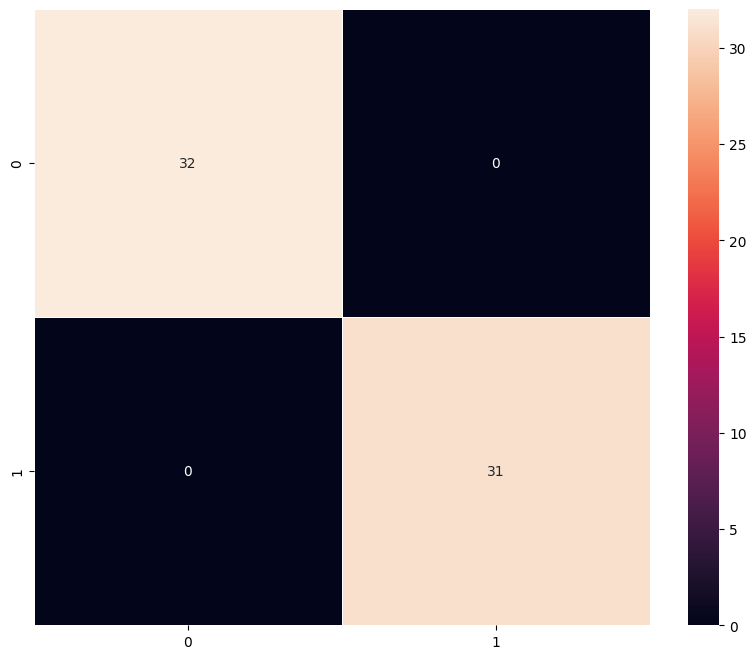

In [149]:
plot_confusion_matrix(model_3,X_val_normalized,y_val_encoded)

#### Visualizing the predictions

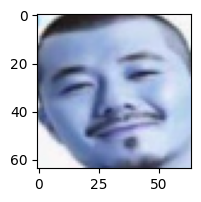

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label [0]
True Label 0


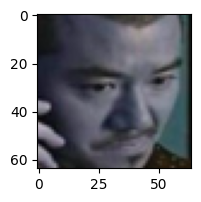

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predicted Label [0]
True Label 1


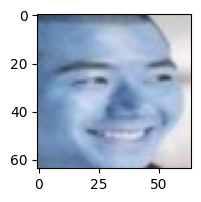

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Label [0]
True Label 1


In [150]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model_3.predict((X_val_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model_3.predict((X_val_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_val[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model_3.predict((X_val_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

**Data augmentation will not be used in the validation/test data set**.

In [151]:
#Builidng Model_4 using VGG16 base, followed by a feed-forward network, flattening, dense layers, dropout, and a sigmoid output layer.
# Data augmentation will be added later
model_4 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_4.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_4.add(Flatten())

#Adding the Feed Forward neural network
model_4.add(Dense(256,activation='relu'))
model_4.add(Dropout(rate=0.4))
model_4.add(Dense(32,activation='relu'))

# Adding a dense output layer
model_4.add(Dense(1, activation='sigmoid'))

#### Visualizing the predictions

In [152]:
opt=Adam()
# Compile model
model_4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [153]:
# Generating the summary of the model
model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,247,489 (58.16 MB)

 Trainable params: 532,801 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [154]:
# Applying data augmentation
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2,shear_range=0.3,zoom_range=0.4
                              )

In [155]:
# Training model_4 using data from train_datagen with batching and validation
history_vgg16 = model_4.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5506 - loss: 0.7497 - val_accuracy: 0.9683 - val_loss: 0.2900
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8594 - loss: 0.4166 - val_accuracy: 0.9683 - val_loss: 0.1821
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.9555 - loss: 0.2425 - val_accuracy: 0.9841 - val_loss: 0.0703
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0949 - val_accuracy: 0.9683 - val_loss: 0.0566
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.9500 - loss: 0.1290 - val_accuracy: 1.0000 - val_loss: 0.0180
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9922 - loss: 0.0391 - val_accuracy: 1.0000 - val_loss: 0.0170
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step - accuracy: 0.9854 - loss: 0.0547 - val_accuracy: 0.9841 - val_loss: 0.0222
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9844 - loss: 0.0337 - val_accuracy: 1.0000 - val_loss: 0.0181

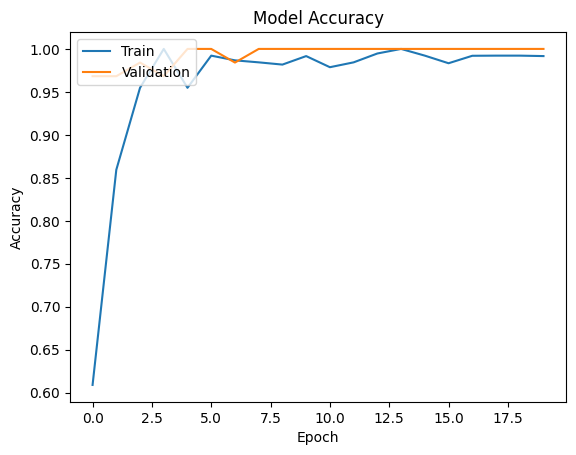

In [156]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [157]:
model_4_train_perf = model_performance_classification(model_4, X_train_normalized,y_train_encoded)

print("Train performance metrics")
print(model_4_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


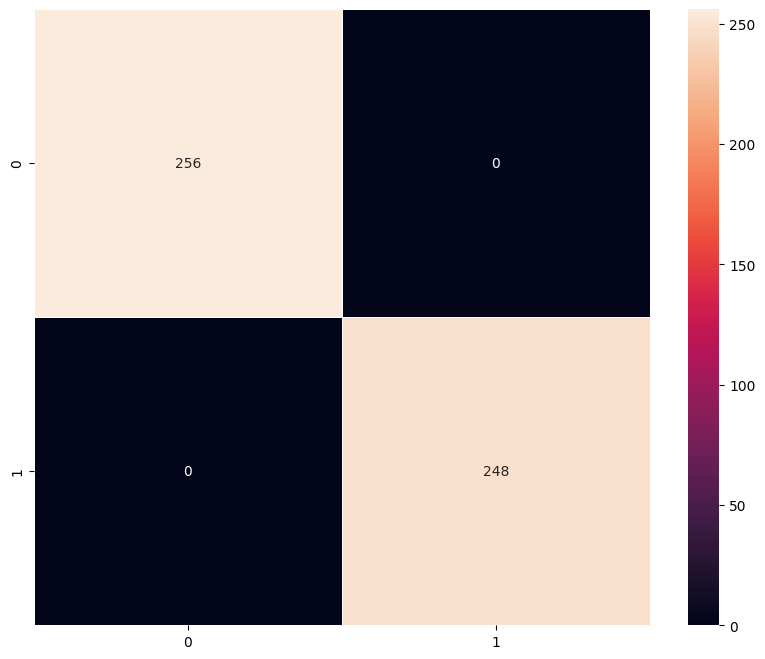

In [158]:
plot_confusion_matrix(model_4,X_train_normalized,y_train_encoded)

In [159]:
model_4_valid_perf = model_performance_classification(model_4, X_val_normalized,y_val_encoded)

print("Validation performance metrics")
print(model_4_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


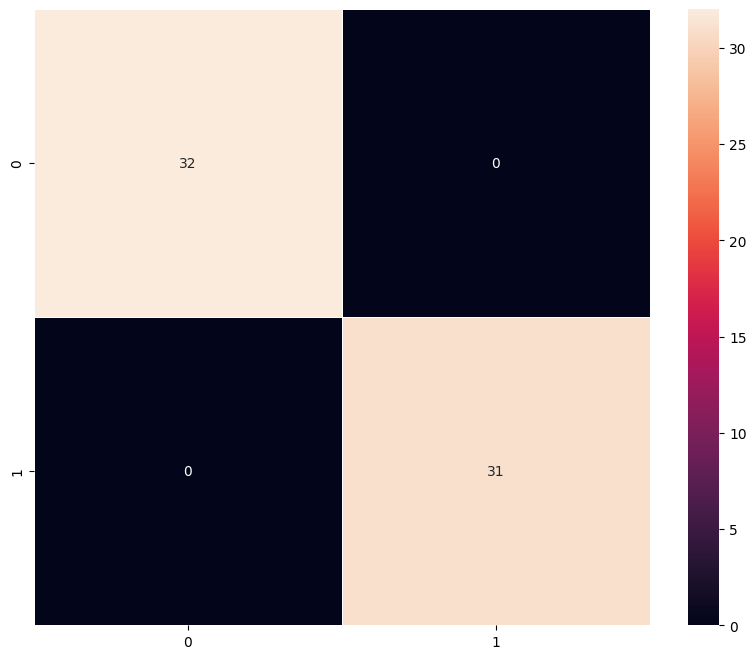

In [160]:
plot_confusion_matrix(model_4,X_val_normalized,y_val_encoded)

#### Visualizing the prediction

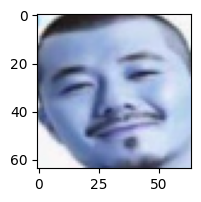

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicted Label [0]
True Label 0


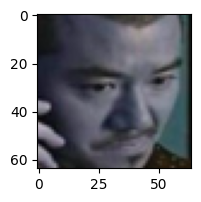

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Label [0]
True Label 1


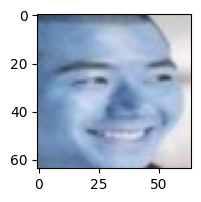

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Label [0]
True Label 1


In [161]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_val[2])
plt.show()
print('Predicted Label', enc.inverse_transform(model_4.predict((X_val_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
print('Predicted Label', enc.inverse_transform(model_4.predict((X_val_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_val[36])
plt.show()
print('Predicted Label', enc.inverse_transform(model_4.predict((X_val_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

# **Model Performance Comparison and Final Model Selection**

In [162]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [163]:
models_valid_comp_df = pd.concat(
    [
        model_2_valid_perf.T,
        model_3_valid_perf.T,
        model_4_valid_perf.T

    ],
    axis=1,
)
models_valid_comp_df.columns = [
 "VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [164]:
models_train_comp_df

,VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.996032,1.0,1.0
Recall,0.996032,1.0,1.0
Precision,0.996032,1.0,1.0
F1 Score,0.996032,1.0,1.0


In [165]:
models_valid_comp_df

,VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,1.0,1.0,1.0
Recall,1.0,1.0,1.0
Precision,1.0,1.0,1.0
F1 Score,1.0,1.0,1.0


In [166]:
models_train_comp_df - models_valid_comp_df

,VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,-0.003968,0.0,0.0
Recall,-0.003968,0.0,0.0
Precision,-0.003968,0.0,0.0
F1 Score,-0.003968,0.0,0.0


**Model 4** is selected as the final model due to its perfect validation performance and the effective use of data augmentation, which enhances generalization and improves robustness to variations in real-world data.

## Test Performance

In [167]:
model_4_test_perf = model_performance_classification(model_4, X_test_normalized,y_test_encoded)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [168]:
model_4_test_perf

,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


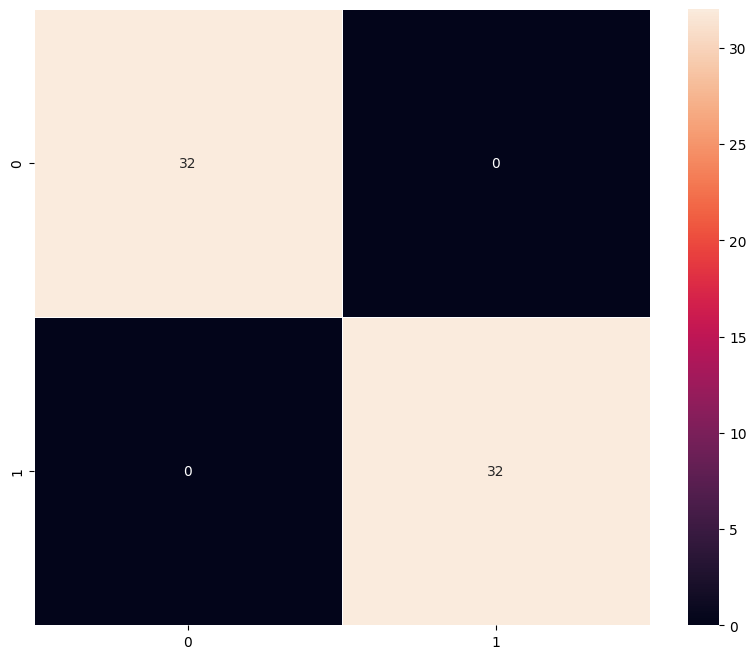

In [169]:
plot_confusion_matrix(model_4, X_test_normalized,y_test_encoded)

# **Actionable Insights & Recommendations**

**Insights**

* **High Performance on Both Training and Validation Data**: Model 4 (VGG-16 with Feed-forward Neural Network and Data Augmentation) achieved perfect scores on both training and validation datasets, demonstrating its ability to generalize well and classify helmet-wearing workers accurately.


* **Impact of Data Augmentation**: The inclusion of data augmentation techniques significantly improved the model's performance by reducing overfitting and ensuring the model could better generalize to real-world variations such as different poses, lighting, and angles.

* **Transfer Learning Effectiveness**: The VGG-16 base model proved effective in feature extraction, and further refinements with a feed-forward neural network helped adapt these features specifically to the helmet detection task, improving model accuracy.

* **No Overfitting in Final Model** :Despite the complex nature of the task, Model 4 did not show signs of overfitting, likely due to the combination of a strong pre-trained model, fine-tuning with additional layers, and the regularization provided by data augmentation.


**Recommendations**

* **Ensure Continuous Monitoring with Augmented Data**: It is recommended to continue using data augmentation during model training to maintain the model’s ability to generalize to real-world images, as this prevents overfitting and ensures better performance in dynamic environments.

* **Expand the Dataset for More Robustness**: While the model performs well, it can be further improved by expanding the dataset to include a wider variety of helmet types, worker attire, and environmental conditions (e.g., different lighting or weather conditions).

* **Improving Model 4**: Collecting more real-time data and retraining periodically will ensure the model adapts to evolving helmet usage patterns and environmental changes.

In [172]:
!jupyter nbconvert /content/drive/MyDrive/Colab_Notebooks/Sujata_Surendranathan_Project_6.ipynb --to html

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab_Notebooks/Sujata_Surendranathan_Project_6.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 30 image(s).
[NbConvertApp] Writing 3201075 bytes to /content/drive/MyDrive/Colab_Notebooks/Sujata_Surendranathan_Project_6.html
